In [51]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [52]:
class HateSpeechRFClassifier:
    def __init__(self, threshold: float = 0.75, n_estimators: int = 100, max_depth: int = None, class_weight=None):
        self.threshold = threshold
        self.encoder = SentenceTransformer("all-MiniLM-L6-v2")
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42
        )

    def embed(self, texts: pd.Series) -> np.ndarray:
        return self.encoder.encode(texts.tolist(), show_progress_bar=False)

    def train(self, X: pd.Series, y: pd.Series) -> None:
        X_embed = self.embed(X)
        self.model.fit(X_embed, y)

    def predict_proba(self, X: pd.Series) -> pd.Series:
        X_embed = self.embed(X)
        proba = self.model.predict_proba(X_embed)[:, 1]
        return pd.Series(proba, index=X.index)

    def predict(self, X: pd.Series) -> pd.Series:
        proba = self.predict_proba(X)
        return (proba > self.threshold).astype(int)

    def evaluate(self, X_test: pd.Series, y_test: pd.Series) -> None:
        y_pred = self.predict(X_test)
        print(classification_report(y_test, y_pred))

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hate", "Hate"], yticklabels=["Not Hate", "Hate"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def show_misclassifications(self, X: pd.Series, y_true: pd.Series, y_pred: pd.Series):
        mismatches = X[(y_true != y_pred)]
        print("\nFALSE POSITIVES:")
        print(mismatches[(y_true == 0) & (y_pred == 1)].head(5).to_string(index=False))

        print("\nFALSE NEGATIVES:")
        print(mismatches[(y_true == 1) & (y_pred == 0)].head(5).to_string(index=False))


In [53]:
def main():
    train_df = pd.read_csv("../data/train_data.csv", sep=";")

    model = HateSpeechRFClassifier(threshold=0.22, class_weight="balanced")

    X_train, X_val, y_train, y_val = train_test_split(
        train_df["comment"],
        train_df["isHate"].astype(int),
        test_size=0.2,
        random_state=42
    )

    model.train(X_train, y_train)
    model.evaluate(X_val, y_val)

    val_probs = model.predict_proba(X_val)
    val_preds = model.predict(X_val)

    model.plot_confusion_matrix(y_val, val_preds)
    model.show_misclassifications(X_val, y_val, val_preds)

    val_df = pd.DataFrame({
        "comment": X_val,
        "true_label": y_val,
        "probability": val_probs,
        "prediction": val_preds
    })
    val_df.to_csv("../data/hate_speech_val_predictions_rf.csv", index=False)

    misclassified = val_df[val_df["true_label"] != val_df["prediction"]]
    misclassified.to_csv("../data/misclassified_val_examples.csv", index=False)

    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(y_val, val_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Validation Data")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    from sklearn.metrics import precision_recall_curve, average_precision_score

    precision, recall, thresholds = precision_recall_curve(y_val, val_probs)
    avg_prec = average_precision_score(y_val, val_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"PR curve (AP = {avg_prec:.2f})", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Validation Data")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    from sklearn.metrics import f1_score

    best_f1 = 0
    best_thresh = 0

    for thresh in thresholds:
        preds = (val_probs > thresh).astype(int)
        score = f1_score(y_val, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh

    print(f"Best threshold by F1: {best_thresh:.3f} → F1 = {best_f1:.3f}")


              precision    recall  f1-score   support

           0       0.94      0.84      0.89       172
           1       0.41      0.68      0.51        28

    accuracy                           0.82       200
   macro avg       0.68      0.76      0.70       200
weighted avg       0.87      0.82      0.84       200



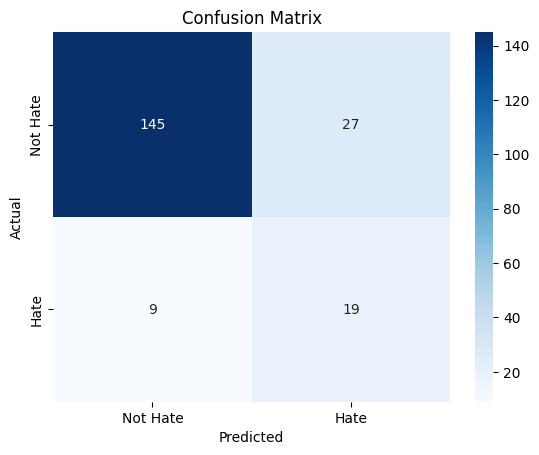


FALSE POSITIVES:
IM GAY AND FUCKING PROUD FUCK BITCHES LIKE THES...
                            incoming racist people
                     Slow death to people like you
                           Fucking good punch dude
        Why are we not allowed to kill christians?

FALSE NEGATIVES:
She is heavily relying on him to turn the other...
Watching this kid trying to step up and walk wi...
who gives aa fuck about shit diamonds from the ...
If men shouldnt hit women because we are physic...
I don’t think you have the right to write comme...


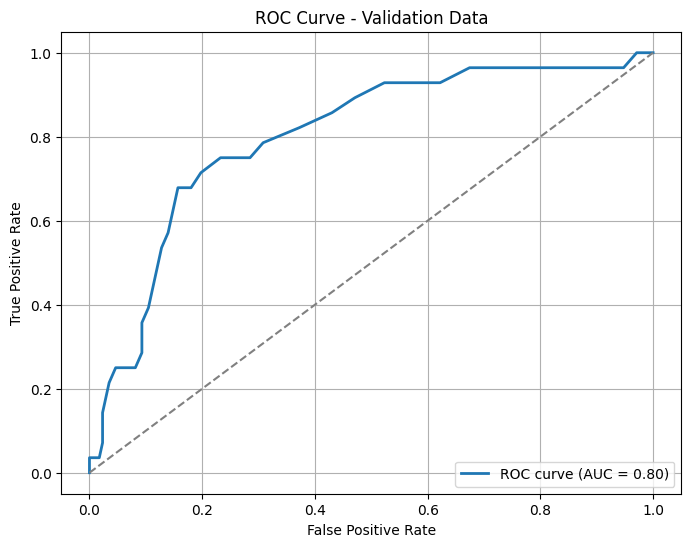

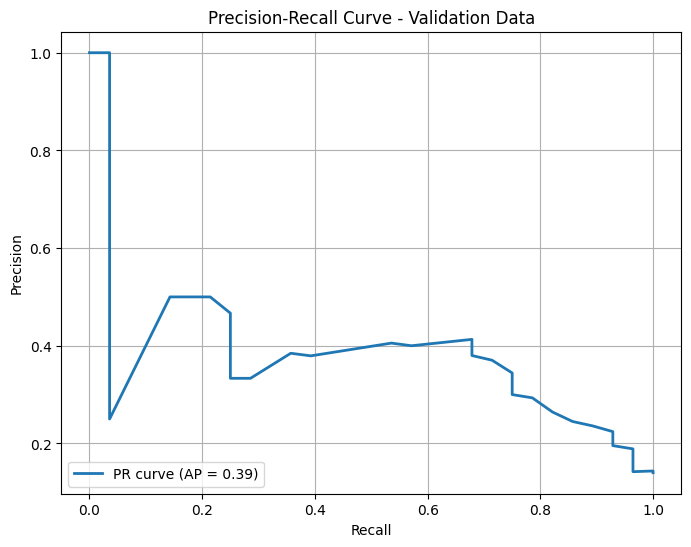

Best threshold by F1: 0.220 → F1 = 0.514


In [54]:
main()